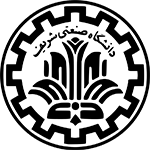

<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<font color=0F5298 size=7>
 Deep Learning <br>
<font color=2565AE size=5>
Electrical Engineering Department - Fall 2025  <br>
<font color=3C99D size=5>
          Homework 4<br>
<font color=696880 size=4>

**Name**: Ali Soltani
  
**Student ID**: 403203449

# **Variational Auto-Encoder (VAE)**

Variational Auto-Encoders (VAEs) are a widely used class of generative models. They are simple to implement and, in contrast to other generative model classes like Generative Adversarial Networks, they optimize an explicit maximum likelihood objective to train the model. Finally, their architecture makes them well-suited for unsupervised representation learning, i.e., learning low-dimensional representations of high-dimenionsal inputs, like images, with only self-supervised objectives (data reconstruction in the case of VAEs).

**By working on this problem you will learn and practice the following steps:**
1. Set up a data loading pipeline in PyTorch.
2. Implement, train and visualize an auto-encoder architecture.
3. Extend your implementation to a variational auto-encoder.
4. Learn how to tune the critical beta parameter of your VAE.
5. Inspect the learned representation of your VAE.
6. Extend VAE's generative capabilities by conditioning it on the label you wish to generate.



# 1. MNIST Dataset[5 pt]

We will perform all experiments for this problem using the [MNIST dataset](http://yann.lecun.com/exdb/mnist/), a standard dataset of handwritten digits. The main benefits of this dataset are that it is small and relatively easy to model. It therefore allows for quick experimentation and serves as initial test bed in many papers.


In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,2"

In [3]:
import torch
import torchvision
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')   # use GPU if available
print(f"Using device: {device}")

Using device: cuda:0


In [14]:
# this will automatically download the MNIST training set
mnist_train = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=torchvision.transforms.ToTensor())
print("\n Download complete! Downloaded {} training examples!".format(len(mnist_train)))

100.0%
100.0%
100.0%
100.0%


 Download complete! Downloaded 60000 training examples!


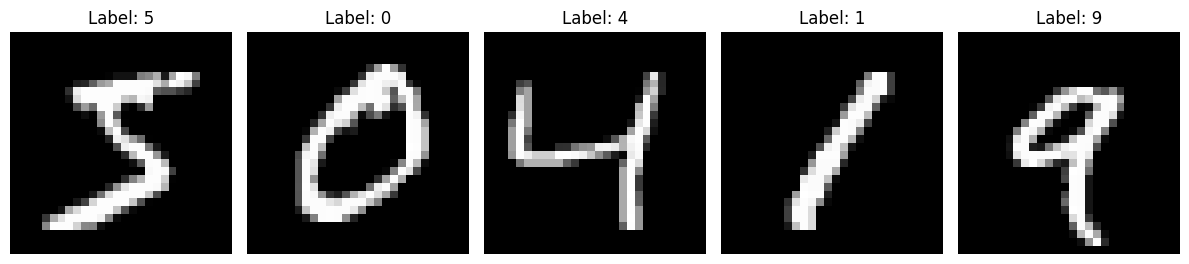

In [12]:
# TODO
# Display some of the training samples.
fig, axes = plt.subplots(1, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    img, label = mnist_train[i]
    ax.imshow(img.squeeze(), cmap='gray')
    ax.set_title(f'Label: {label}')
    ax.axis('off')
plt.tight_layout()
plt.show()

# 2. Auto-Encoder[35 pt]

Before implementing the full VAE, we will first implement an **auto-encoder architecture**. Auto-encoders use an encoder–decoder architecture to learn low-dimensional representations of data without supervision. The encoder compresses the input image into a small latent vector using fully connected layers, and the decoder maps this vector back to the original image space. The model is trained by minimizing a reconstruction loss between the input and the reconstructed output. Because image pixels contain redundant information, the auto-encoder can learn a compact embedding that still preserves key features such as digit identity and shape. This compressed representation can make downstream tasks easier. In this assignment, you will define encoder and decoder networks and then train the auto-encoder.

Learning such a **compressed representation can make downstream task learning easier**. For example, learning to add two numbers based on the inferred digits is much easier than performing the task based on two piles of pixel values that depict the digits.

In the following, we will first define the architecture of encoder and decoder and then train the auto-encoder model.

## Defining the Auto-Encoder Architecture[10 pt]

In [5]:
import torch.nn as nn
class Encoder(nn.Module):
  def __init__(self, nz, input_size):
    super().__init__()
    self.input_size = input_size
    self.net = nn.Sequential(
      nn.Flatten(),
      nn.Linear(input_size, 512),
      nn.ReLU(),
      nn.Linear(512, 256),
      nn.ReLU(),
      nn.Linear(256, nz)
    )

  def forward(self, x):
    return self.net(x)


class Decoder(nn.Module):
  def __init__(self, nz, output_size):
    super().__init__()
    self.output_size = output_size
    self.net = nn.Sequential(
      nn.Linear(nz, 256),
      nn.ReLU(),
      nn.Linear(256, 512),
      nn.ReLU(),
      nn.Linear(512, output_size),
      nn.Sigmoid()
    )

  def forward(self, z):
    return self.net(z).reshape(-1, 1, int(self.output_size**0.5), int(self.output_size**0.5))

## Testing the Auto-Encoder Forward Pass[5 pt]

To verify that your auto-encoder is implemented correctly, you will create a DataLoader for sampling training batches and then run a forward pass through the encoder and decoder. This test ensures that your networks accept inputs of the expected shape and produce latent vectors and reconstructions with the correct dimensions.

In [15]:
batch_size = 64
nworkers = 2

mnist_data_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=nworkers)

in_size = out_size = 28*28
nz = 32
encoder = Encoder(nz=nz, input_size=in_size)
decoder = Decoder(nz=nz, output_size=out_size)

for sample_img, sample_label in mnist_data_loader:
    input = sample_img.reshape([batch_size, in_size])
    print(f'{sample_img.shape=}, {type(sample_img)}, {input.shape=}')
    enc = encoder(input)
    print(f"Shape of encoding vector (should be [batch_size, nz]): {enc.shape}")
    dec = decoder(enc)
    print("Shape of decoded image (should be [batch_size, 1, out_size]): {}.".format(dec.shape))
    break


sample_img.shape=torch.Size([64, 1, 28, 28]), <class 'torch.Tensor'>, input.shape=torch.Size([64, 784])
Shape of encoding vector (should be [batch_size, nz]): torch.Size([64, 32])
Shape of decoded image (should be [batch_size, 1, out_size]): torch.Size([64, 1, 28, 28]).


Now that we defined encoder and decoder network our architecture is nearly complete. However, before we start training, we can wrap encoder and decoder into an auto-encoder class for easier handling.

In [7]:
class AutoEncoder(nn.Module):
  def __init__(self, nz):
    super().__init__()
    self.encoder = Encoder(nz=nz, input_size=28*28)
    self.decoder = Decoder(nz=nz, output_size=28*28)

  def forward(self, x):
    z = self.encoder(x)
    x_recon = self.decoder(z)
    return x_recon

  def reconstruct(self, x):
    """Only used later for visualization."""
    with torch.no_grad():
      image = self.forward(x)
    return image

## Setting up the Auto-Encoder Training Loop[5 pt]
After implementing the network architecture, we can now set up the training loop and run training.

In [19]:
epochs = 10
learning_rate = 1e-3

print(f'Device available {device}')
ae_model = AutoEncoder(nz).to(device)
ae_model = ae_model.train()

optimizer = torch.optim.Adam(ae_model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

train_it = 0
for ep in range(epochs):
    print("Run Epoch {}".format(ep))
    for data, _ in mnist_data_loader:
        data = data.to(device)
        optimizer.zero_grad()
        recon = ae_model(data)
        rec_loss = criterion(recon, data)
        rec_loss.backward()
        optimizer.step()
        train_it += 1
        if train_it % 100 == 0:
            print(f"Iteration {train_it}, Loss: {rec_loss.item():.4f}")

print("Done!")
del epochs, learning_rate, data, train_it, rec_loss


Device available cuda:0
Run Epoch 0
Iteration 100, Loss: 0.0612
Iteration 200, Loss: 0.0420
Iteration 300, Loss: 0.0298
Iteration 400, Loss: 0.0250
Iteration 500, Loss: 0.0244
Iteration 600, Loss: 0.0230
Iteration 700, Loss: 0.0177
Iteration 800, Loss: 0.0200
Iteration 900, Loss: 0.0166
Run Epoch 1
Iteration 1000, Loss: 0.0164
Iteration 1100, Loss: 0.0154
Iteration 1200, Loss: 0.0149
Iteration 1300, Loss: 0.0139
Iteration 1400, Loss: 0.0126
Iteration 1500, Loss: 0.0161
Iteration 1600, Loss: 0.0118
Iteration 1700, Loss: 0.0118
Iteration 1800, Loss: 0.0122
Run Epoch 2
Iteration 1900, Loss: 0.0120
Iteration 2000, Loss: 0.0122
Iteration 2100, Loss: 0.0108
Iteration 2200, Loss: 0.0101
Iteration 2300, Loss: 0.0107
Iteration 2400, Loss: 0.0095
Iteration 2500, Loss: 0.0098
Iteration 2600, Loss: 0.0086
Iteration 2700, Loss: 0.0093
Iteration 2800, Loss: 0.0087
Run Epoch 3
Iteration 2900, Loss: 0.0086
Iteration 3000, Loss: 0.0083
Iteration 3100, Loss: 0.0095
Iteration 3200, Loss: 0.0083
Iteration

## Verifying reconstructions[5 pt]
Now that we trained the auto-encoder we can visualize some of the reconstructions on the test set to verify that it is converged and did not overfit. **Before continuing, make sure that your auto-encoder is able to reconstruct these samples near-perfectly.**

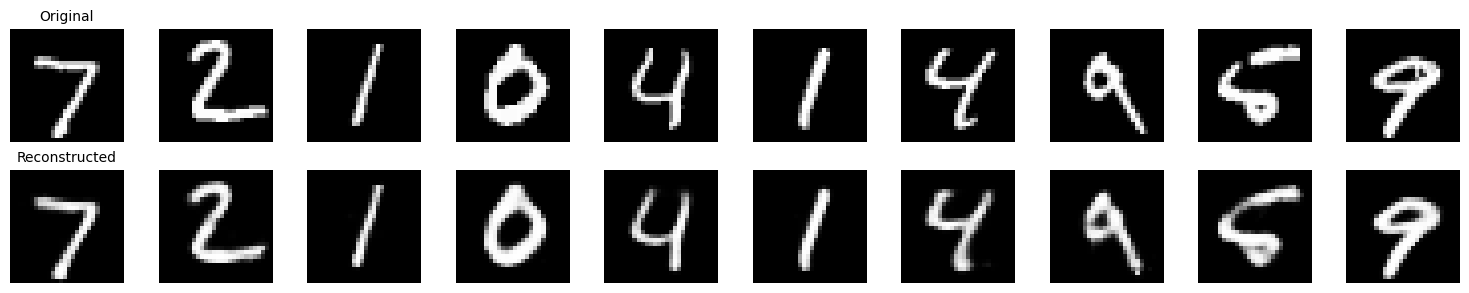

In [20]:
def vis_reconstruction(model, randomize=False):
    mnist_test = torchvision.datasets.MNIST(
        root='./data',
        train=False,
        download=True,
        transform=torchvision.transforms.ToTensor()
    )
    model.eval()
    
    if randomize:
        indices = torch.randperm(len(mnist_test))[:10]
    else:
        indices = range(10)
    
    fig, axes = plt.subplots(2, 10, figsize=(15, 3))
    
    for i, idx in enumerate(indices):
        img, label = mnist_test[idx]
        img_input = img.unsqueeze(0).to(device)
        
        recon = model.reconstruct(img_input)
        
        axes[0, i].imshow(img.squeeze().cpu(), cmap='gray')
        axes[0, i].axis('off')
        if i == 0:
            axes[0, i].set_title('Original', fontsize=10)
        
        axes[1, i].imshow(recon.squeeze().cpu(), cmap='gray')
        axes[1, i].axis('off')
        if i == 0:
            axes[1, i].set_title('Reconstructed', fontsize=10)
    
    plt.tight_layout()
    plt.show()

vis_reconstruction(ae_model, randomize=False)


## Sampling from the Auto-Encoder[5 pt]

To test whether the auto-encoder is useful as a generative model, we can use it like any other generative model: draw embedding samples from a prior distribution and decode them through the decoder network. We will choose a unit Gaussian prior to allow for easy comparison to the VAE later.

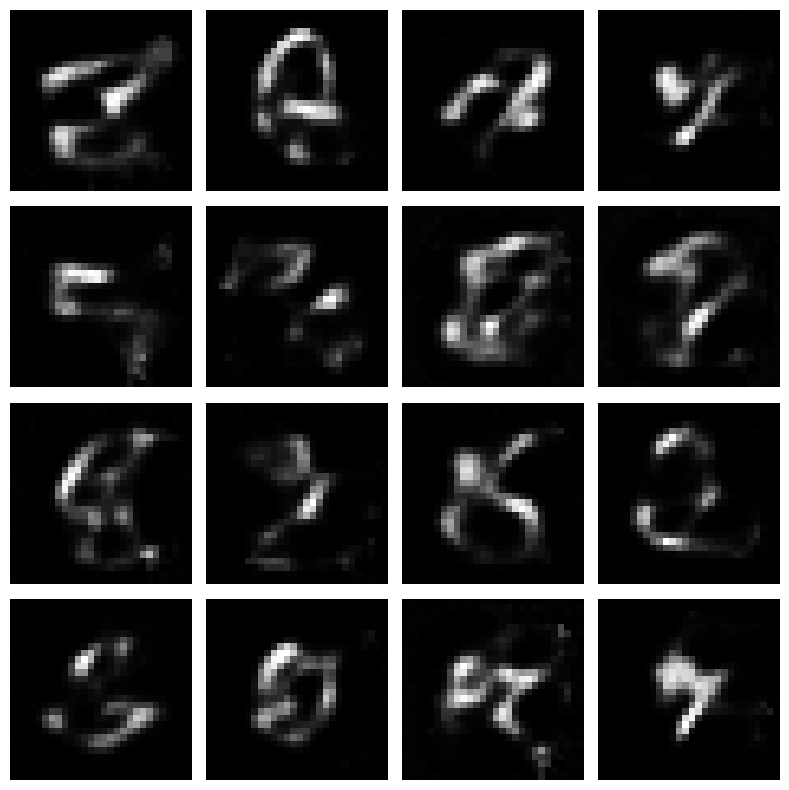

In [21]:
# we will sample N embeddings, then decode and visualize them
def vis_samples(model):
    model.eval()
    
    N = 16
    z_samples = torch.randn(N, nz).to(device)
    
    with torch.no_grad():
        samples = model.decoder(z_samples)
    
    fig, axes = plt.subplots(4, 4, figsize=(8, 8))
    
    for i in range(N):
        row = i // 4
        col = i % 4
        axes[row, col].imshow(samples[i].squeeze().cpu(), cmap='gray')
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()


vis_samples(ae_model)

>**Inline Question: Describe your observations, why do you think they occur? [5 pt]**

The sampled images from the auto-encoder appear noisy, blurry, or don't resemble realistic digits. This occurs because the auto-encoder has no regularization on its latent space during training. The encoder learns to map training images to arbitrary, scattered points in the latent space without any structure. When we sample from a standard Gaussian prior, these random points likely fall in regions of the latent space that the decoder never encountered during training, so it produces meaningless outputs.

# 3. Variational Auto-Encoder (VAE)[35 pt]

Variational auto-encoders use a very similar architecture to deterministic auto-encoders, but are inherently storchastic models, i.e. we perform a stochastic sampling operation during the forward pass, leading to different different outputs every time we run the network for the same input. This sampling is required to optimize the VAE objective also known as the evidence lower bound (ELBO):

$$
p(x) > \underbrace{\mathbb{E}_{z\sim q(z\vert x)} p(x \vert z)}_{\text{reconstruction}} - \underbrace{D_{\text{KL}}\big(q(z \vert x), p(z)\big)}_{\text{prior divergence}}
$$


For simplicity, we will choose a unit Gaussian prior again. The first term is the reconstruction term we already know from training the auto-encoder. When assuming a Gaussian output distribution for both encoder $q(z \vert x)$ and decoder $p(x \vert z)$ the objective reduces to:

$$
\mathcal{L}_{\text{VAE}} = \sum_{x\sim \mathcal{D}} \mathcal{L}_{\text{rec}}(x, \hat{x}) - \beta \cdot D_{\text{KL}}\big(\mathcal{N}(\mu_q, \sigma_q), \mathcal{N}(0, I)\big)
$$


The coefficient $\beta$ is a scalar weighting factor that trades off between reconstruction and regularization objective. We will investigate the influence of this factor in out experiments below.


### Reparametrization Trick

The sampling procedure inside the VAE's forward pass for obtaining a sample $z$ from the posterior distribution $q(z \vert x)$, when implemented naively, is non-differentiable. However, since $q(z\vert x)$ is parametrized with a Gaussian function, there is a simple trick to obtain a differentiable sampling operator, known as the _reparametrization trick_.

Instead of directly sampling $z \sim \mathcal{N}(\mu_q, \sigma_q)$ we can "separate" the network's predictions and the random sampling by computing the sample as:

$$
z = \mu_q + \sigma_q * \epsilon , \quad \epsilon \sim \mathcal{N}(0, I)
$$

Note that in this equation, the sample $z$ is computed as a deterministic function of the network's predictions $\mu_q$ and $\sigma_q$ and therefore allows to propagate gradients through the sampling procedure.

**Note**: While in the equations above the encoder network parametrizes the standard deviation $\sigma_q$ of the Gaussian posterior distribution, in practice we usually parametrize the **logarithm of the standard deviation** $\log \sigma_q$ for numerical stability. Before sampling $z$ we will then exponentiate the network's output to obtain $\sigma_q$.



## Defining the VAE Model [15 pt]

In [9]:
def kl_divergence(mu1, log_sigma1, mu2, log_sigma2):
    kl = 0.5 * torch.sum(torch.exp(2 * log_sigma1) + mu1**2 - 1 - 2 * log_sigma1, dim=1)
    return kl.mean()

class VAE(nn.Module):
  def __init__(self, nz, beta=1.0):
    super().__init__()
    self.beta = beta
    self.encoder = Encoder(nz=nz*2, input_size=28*28)
    self.decoder = Decoder(nz=nz, output_size=28*28)
    self.nz = nz

  def forward(self, x):
    enc = self.encoder(x)
    mu, log_sigma = enc[:, :self.nz], enc[:, self.nz:]
    epsilon = torch.randn_like(mu)
    z = mu + torch.exp(log_sigma) * epsilon
    reconstruction = self.decoder(z)
    q = {'mu': mu, 'log_sigma': log_sigma}
    return {'q': q,
            'rec': reconstruction}

  def loss(self, x, outputs):
    rec_loss = nn.functional.mse_loss(outputs['rec'], x)
    mu = outputs['q']['mu']
    log_sigma = outputs['q']['log_sigma']
    mu_prior = torch.zeros_like(mu)
    log_sigma_prior = torch.zeros_like(log_sigma)
    kl_loss = kl_divergence(mu, log_sigma, mu_prior, log_sigma_prior)
    return rec_loss + self.beta * kl_loss, {'rec_loss': rec_loss, 'kl_loss': kl_loss}

  def reconstruct(self, x):
    """Use mean of posterior estimate for visualization reconstruction."""
    with torch.no_grad():
      enc = self.encoder(x)
      mu = enc[:, :self.nz]
      image = self.decoder(mu)
    return image

## Setting up the VAE Training Loop [5 pt]

Let's start training the VAE model! We will first verify our implementation by setting $\beta = 0$.


Running 10 epochs with beta=0
Run Epoch 0
Iteration 100, Total Loss: 0.0585, Rec Loss: 0.0585, KL Loss: 21.8769
Iteration 200, Total Loss: 0.0470, Rec Loss: 0.0470, KL Loss: 88.6915
Iteration 300, Total Loss: 0.0341, Rec Loss: 0.0341, KL Loss: 196.7077
Iteration 400, Total Loss: 0.0278, Rec Loss: 0.0278, KL Loss: 256.9502
Iteration 500, Total Loss: 0.0235, Rec Loss: 0.0235, KL Loss: 303.4009
Iteration 600, Total Loss: 0.0212, Rec Loss: 0.0212, KL Loss: 322.2424
Iteration 700, Total Loss: 0.0216, Rec Loss: 0.0216, KL Loss: 375.6306
Iteration 800, Total Loss: 0.0191, Rec Loss: 0.0191, KL Loss: 357.4626
Iteration 900, Total Loss: 0.0161, Rec Loss: 0.0161, KL Loss: 360.4808
Run Epoch 1
Iteration 1000, Total Loss: 0.0161, Rec Loss: 0.0161, KL Loss: 378.2731
Iteration 1100, Total Loss: 0.0148, Rec Loss: 0.0148, KL Loss: 401.3440
Iteration 1200, Total Loss: 0.0157, Rec Loss: 0.0157, KL Loss: 445.2894
Iteration 1300, Total Loss: 0.0122, Rec Loss: 0.0122, KL Loss: 391.4723
Iteration 1400, Total

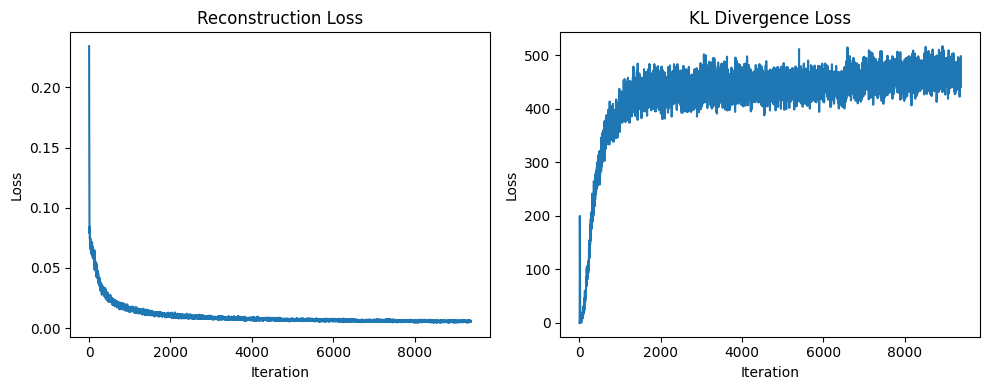

In [33]:
learning_rate = 1e-3
nz = 32
beta = 0
epochs = 10

vae_model = VAE(nz, beta).to(device)
vae_model = vae_model.train()
optimizer = torch.optim.Adam(vae_model.parameters(), lr=learning_rate)



train_it = 0
rec_loss, kl_loss = [], []
print(f"Running {epochs} epochs with {beta=}")
for ep in range(epochs):
    print("Run Epoch {}".format(ep))
    for data, _ in mnist_data_loader:
        data = data.to(device)
        optimizer.zero_grad()
        outputs = vae_model(data)
        loss, losses = vae_model.loss(data, outputs)
        loss.backward()
        optimizer.step()
        rec_loss.append(losses['rec_loss'])
        kl_loss.append(losses['kl_loss'])
        train_it += 1
        if train_it % 100 == 0:
            print(f"Iteration {train_it}, Total Loss: {loss.item():.4f}, Rec Loss: {losses['rec_loss'].item():.4f}, KL Loss: {losses['kl_loss'].item():.4f}")

print("Done!")

rec_loss_plotdata = [foo.detach().cpu() for foo in rec_loss]
kl_loss_plotdata = [foo.detach().cpu() for foo in kl_loss]

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(rec_loss_plotdata)
plt.title('Reconstruction Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.subplot(1, 2, 2)
plt.plot(kl_loss_plotdata)
plt.title('KL Divergence Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.tight_layout()
plt.show()


Let's look at some reconstructions and decoded embedding samples!

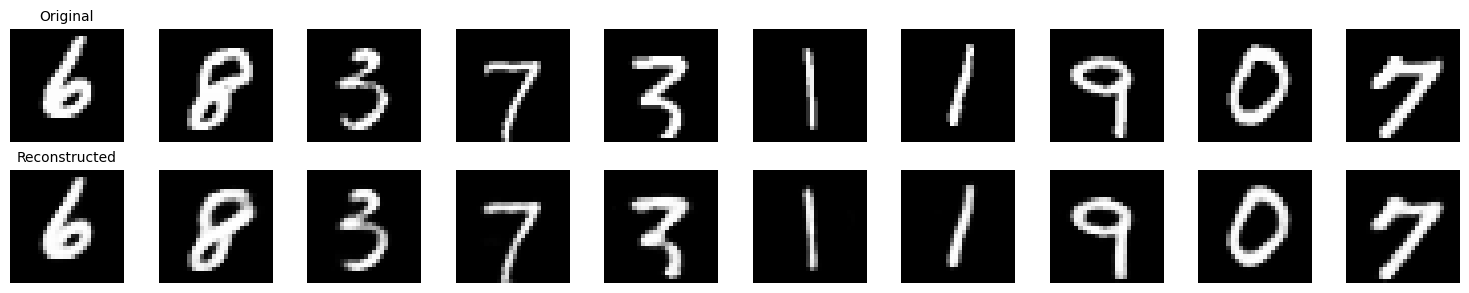

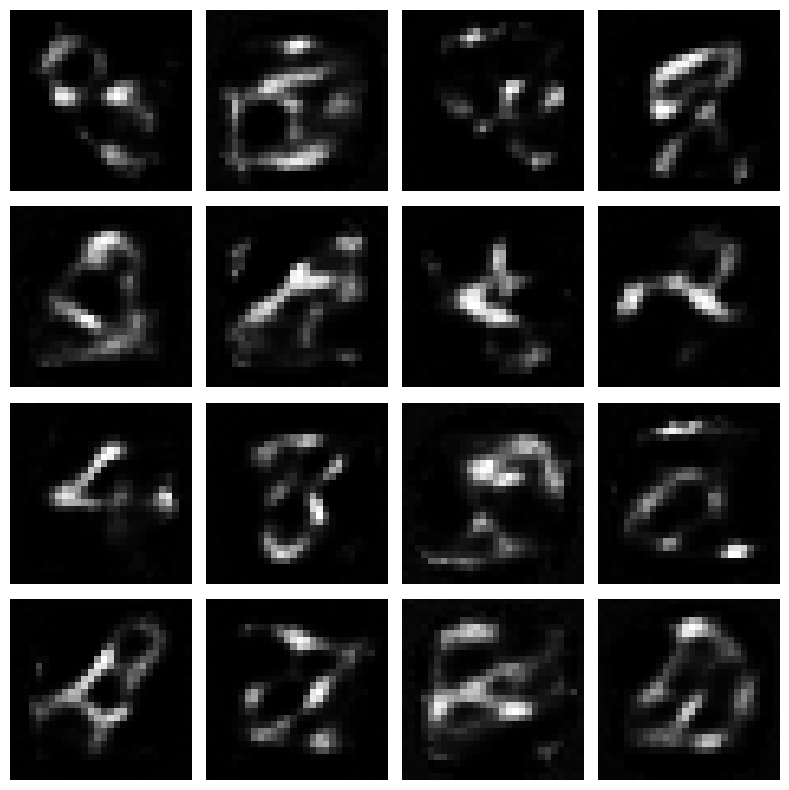

In [34]:
vis_reconstruction(vae_model, randomize=True)
vis_samples(vae_model)

## Tweaking the loss function $\beta$ [2 pt]
Prob1-6: Let's repeat the same experiment for $\beta = 10$, a very high value for the coefficient.

Running 10 epochs with beta=10
Run Epoch 0
Iteration 100, Total Loss: 0.0732, Rec Loss: 0.0703, KL Loss: 0.0003
Iteration 200, Total Loss: 0.0647, Rec Loss: 0.0636, KL Loss: 0.0001
Iteration 300, Total Loss: 0.0692, Rec Loss: 0.0686, KL Loss: 0.0001
Iteration 400, Total Loss: 0.0676, Rec Loss: 0.0672, KL Loss: 0.0000
Iteration 500, Total Loss: 0.0711, Rec Loss: 0.0708, KL Loss: 0.0000
Iteration 600, Total Loss: 0.0662, Rec Loss: 0.0660, KL Loss: 0.0000
Iteration 700, Total Loss: 0.0696, Rec Loss: 0.0694, KL Loss: 0.0000
Iteration 800, Total Loss: 0.0667, Rec Loss: 0.0666, KL Loss: 0.0000
Iteration 900, Total Loss: 0.0696, Rec Loss: 0.0695, KL Loss: 0.0000
Run Epoch 1
Iteration 1000, Total Loss: 0.0648, Rec Loss: 0.0647, KL Loss: 0.0000
Iteration 1100, Total Loss: 0.0649, Rec Loss: 0.0649, KL Loss: 0.0000
Iteration 1200, Total Loss: 0.0675, Rec Loss: 0.0674, KL Loss: 0.0000
Iteration 1300, Total Loss: 0.0648, Rec Loss: 0.0647, KL Loss: 0.0000
Iteration 1400, Total Loss: 0.0680, Rec Loss

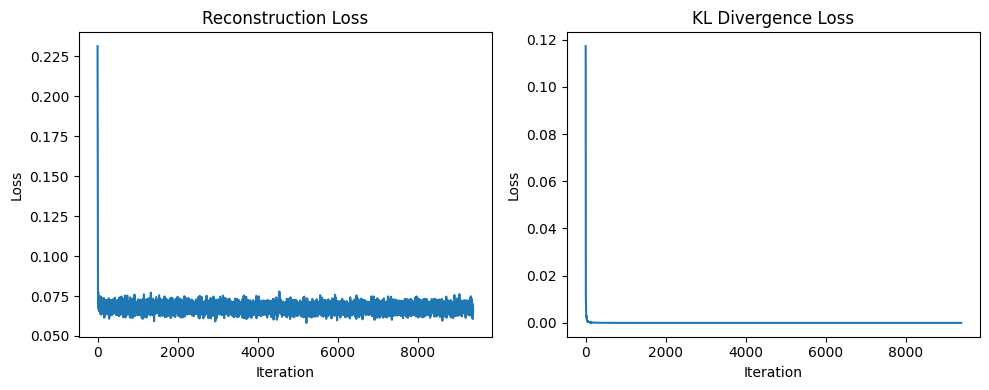

In [27]:
learning_rate = 1e-3
nz = 32
beta = 10
epochs = 10

vae_model = VAE(nz, beta).to(device)
vae_model = vae_model.train()
optimizer = torch.optim.Adam(vae_model.parameters(), lr=learning_rate)



train_it = 0
rec_loss, kl_loss = [], []
print(f"Running {epochs} epochs with {beta=}")
for ep in range(epochs):
    print("Run Epoch {}".format(ep))
    for data, _ in mnist_data_loader:
        data = data.to(device)
        optimizer.zero_grad()
        outputs = vae_model(data)
        loss, losses = vae_model.loss(data, outputs)
        loss.backward()
        optimizer.step()
        rec_loss.append(losses['rec_loss'])
        kl_loss.append(losses['kl_loss'])
        train_it += 1
        if train_it % 100 == 0:
            print(f"Iteration {train_it}, Total Loss: {loss.item():.4f}, Rec Loss: {losses['rec_loss'].item():.4f}, KL Loss: {losses['kl_loss'].item():.4f}")

print("Done!")

rec_loss_plotdata = [foo.detach().cpu() for foo in rec_loss]
kl_loss_plotdata = [foo.detach().cpu() for foo in kl_loss]

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(rec_loss_plotdata)
plt.title('Reconstruction Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.subplot(1, 2, 2)
plt.plot(kl_loss_plotdata)
plt.title('KL Divergence Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.tight_layout()
plt.show()

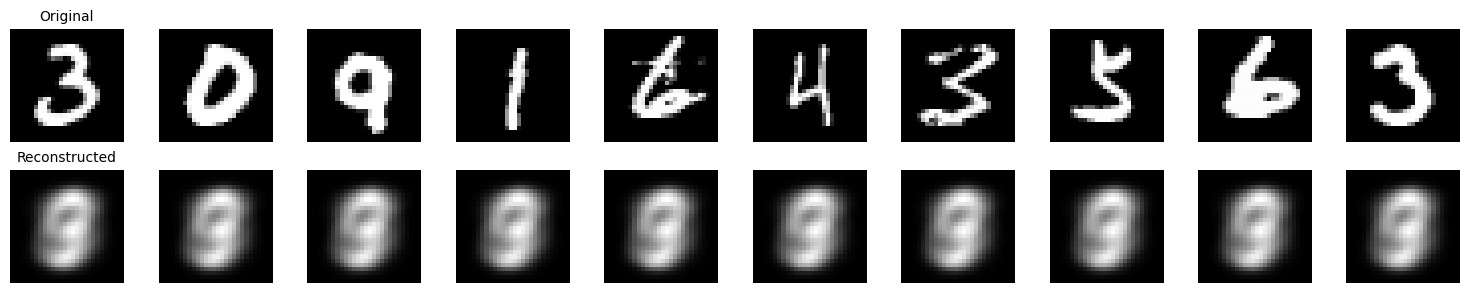

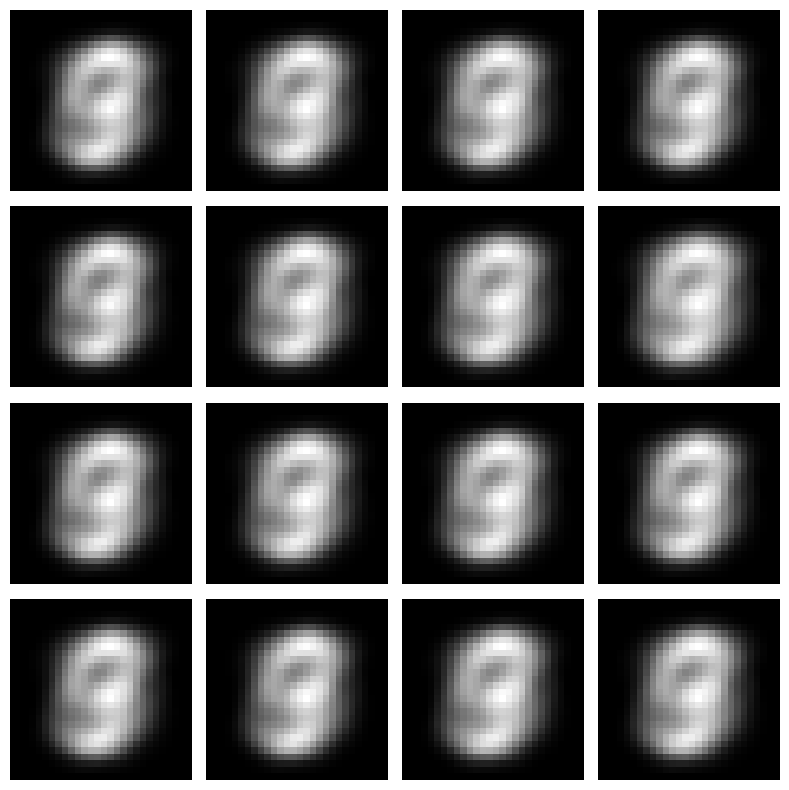

In [29]:
vis_reconstruction(vae_model, randomize=True)
vis_samples(vae_model)

>**Inline Question: What can you observe when setting $\beta = 0$ and $\beta = 10$? Explain your observations! [3 pt]**
With $\beta = 0$, the model acts as a standard auto-encoder with excellent reconstructions but poor samples from the prior, as the latent space is unregularized and KL loss increases. With $\beta = 10$, the KL penalty is too strong, causing posterior collapse where the latent codes become nearly identical, resulting in blurry reconstructions and repetitive samples that all look similar.


## Obtaining the best $\beta$-factor[7 pt]
Prob 1-6 continued: Now we can start tuning the beta value to achieve a good result. First describe what a "good result" would look like (focus what you would expect for reconstructions and sample quality).

>**Inline Question: Characterize what properties you would expect for reconstructions and samples of a well-tuned VAE! [3pt]**
> A well-tuned VAE should have sharp, accurate reconstructions that preserve digit identity and structure. Samples from the prior should generate diverse, realistic-looking digits rather than noise or blurry averages. The latent space should be continuous and structured, with smooth interpolations between points and both losses decreasing during training.

Now that you know what outcome we would like to obtain, try to tune $\beta$ to achieve this result. Logarithmic search in steps of 10x will be helpful, good results can be achieved after ~20 epochs of training. Training reconstructions should be high quality, test samples should be diverse, distinguishable numbers, most samples recognizable as numbers.


Running 10 epochs with beta=0.0035
Run Epoch 0
Iteration 100, Total Loss: 0.0698, Rec Loss: 0.0692, KL Loss: 0.1877
Iteration 200, Total Loss: 0.0650, Rec Loss: 0.0638, KL Loss: 0.3441
Iteration 300, Total Loss: 0.0631, Rec Loss: 0.0607, KL Loss: 0.6835
Iteration 400, Total Loss: 0.0622, Rec Loss: 0.0584, KL Loss: 1.0836
Iteration 500, Total Loss: 0.0647, Rec Loss: 0.0605, KL Loss: 1.2221
Iteration 600, Total Loss: 0.0682, Rec Loss: 0.0646, KL Loss: 1.0069
Iteration 700, Total Loss: 0.0640, Rec Loss: 0.0614, KL Loss: 0.7322
Iteration 800, Total Loss: 0.0658, Rec Loss: 0.0613, KL Loss: 1.3125
Iteration 900, Total Loss: 0.0654, Rec Loss: 0.0622, KL Loss: 0.9251
Run Epoch 1
Iteration 1000, Total Loss: 0.0661, Rec Loss: 0.0609, KL Loss: 1.4891
Iteration 1100, Total Loss: 0.0604, Rec Loss: 0.0554, KL Loss: 1.4201
Iteration 1200, Total Loss: 0.0651, Rec Loss: 0.0585, KL Loss: 1.8630
Iteration 1300, Total Loss: 0.0634, Rec Loss: 0.0558, KL Loss: 2.1704
Iteration 1400, Total Loss: 0.0606, Rec 

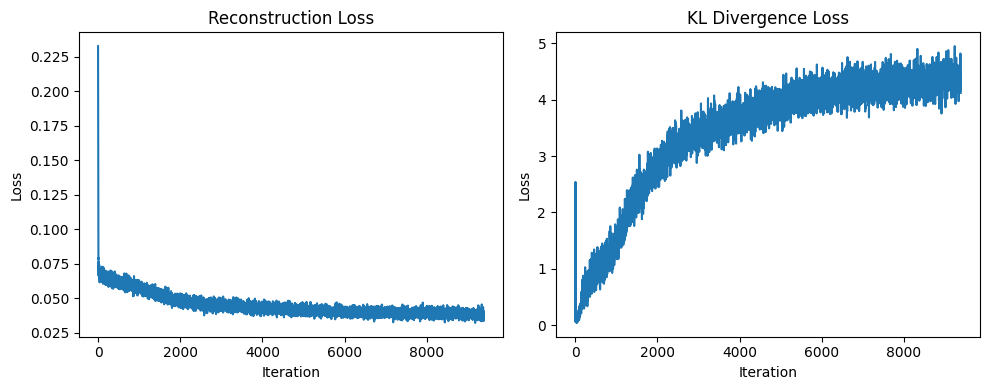

In [16]:
# Tuning for best beta
learning_rate = 1e-3
nz = 32
beta = 0.0035
epochs = 10

vae_model = VAE(nz, beta).to(device)
vae_model = vae_model.train()
optimizer = torch.optim.Adam(vae_model.parameters(), lr=learning_rate)



train_it = 0
rec_loss, kl_loss = [], []
print(f"Running {epochs} epochs with {beta=}")
for ep in range(epochs):
    print("Run Epoch {}".format(ep))
    for data, _ in mnist_data_loader:
        data = data.to(device)
        optimizer.zero_grad()
        outputs = vae_model(data)
        loss, losses = vae_model.loss(data, outputs)
        loss.backward()
        optimizer.step()
        rec_loss.append(losses['rec_loss'])
        kl_loss.append(losses['kl_loss'])
        train_it += 1
        if train_it % 100 == 0:
            print(f"Iteration {train_it}, Total Loss: {loss.item():.4f}, Rec Loss: {losses['rec_loss'].item():.4f}, KL Loss: {losses['kl_loss'].item():.4f}")

print("Done!")

rec_loss_plotdata = [foo.detach().cpu() for foo in rec_loss]
kl_loss_plotdata = [foo.detach().cpu() for foo in kl_loss]

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(rec_loss_plotdata)
plt.title('Reconstruction Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.subplot(1, 2, 2)
plt.plot(kl_loss_plotdata)
plt.title('KL Divergence Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.tight_layout()
plt.show()

BEST beta =  0.0035


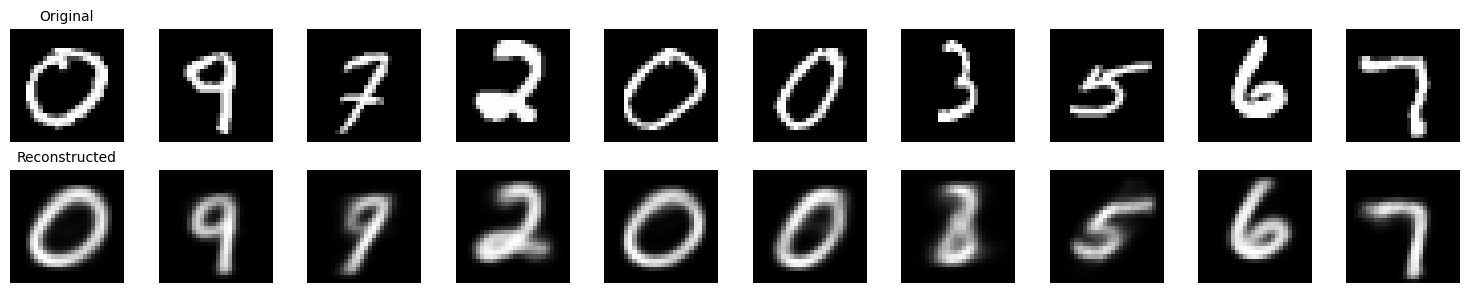

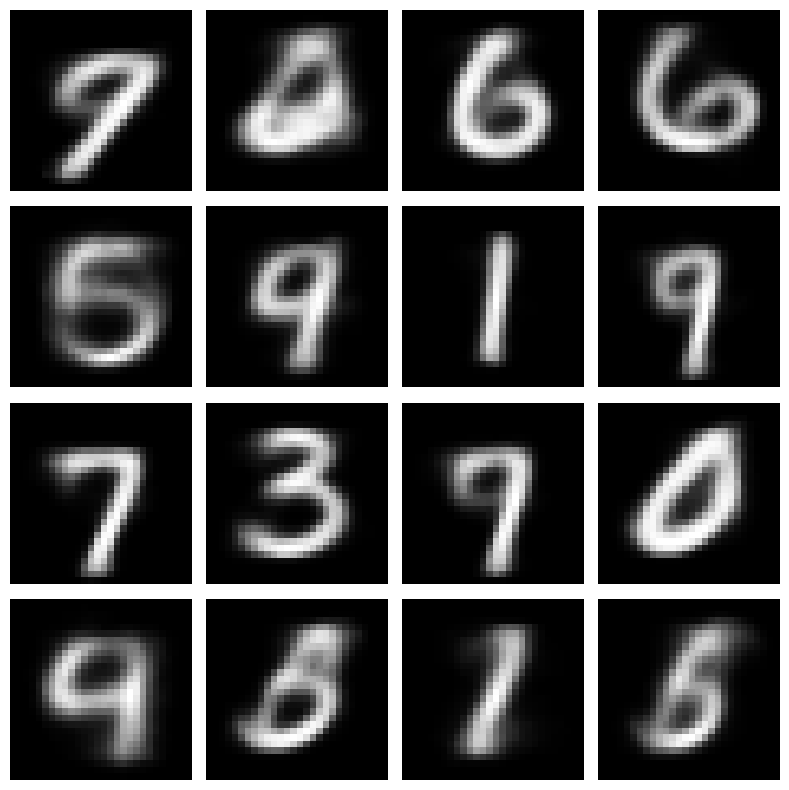

In [22]:
print("BEST beta = ", beta)
vis_reconstruction(vae_model, randomize=True)
vis_samples(vae_model)

# 4. Embedding Space Interpolation[8 pt]

As mentioned in the introduction, AEs and VAEs cannot only be used to generate images, but also to learn low-dimensional representations of their inputs. In this final section we will investigate the representations we learned with both models by **interpolating in embedding space** between different images. We will encode two images into their low-dimensional embedding representations, then interpolate these embeddings and reconstruct the result.

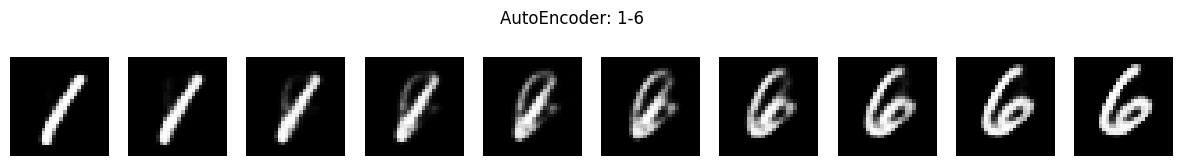

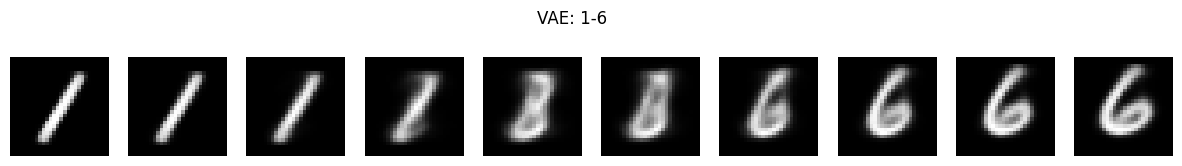

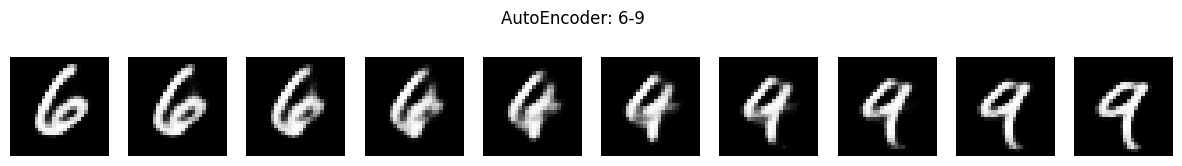

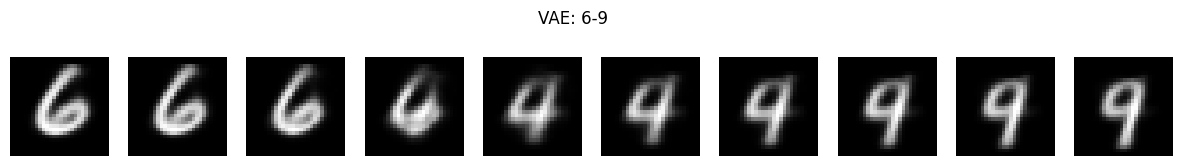

In [27]:
nz=32

def get_image_with_label(target_label):
  """Returns a random image from the training set with the requested digit."""
  for img, label in mnist_train:
    if label == target_label:
        return img.to(device)

def interpolate_and_visualize(model, tag, start_img, end_img):
  """Encodes images and performs interpolation. Displays decodings."""
  model.eval()
  with torch.no_grad():
    start_enc = model.encoder(start_img.unsqueeze(0))
    end_enc = model.encoder(end_img.unsqueeze(0))
    
    if isinstance(model, VAE):
      start_z = start_enc[:, :nz]
      end_z = end_enc[:, :nz]
    else:
      start_z = start_enc
      end_z = end_enc
    
    num_steps = 10
    interpolations = []
    for alpha in torch.linspace(0, 1, num_steps):
      z_interp = (1 - alpha) * start_z + alpha * end_z
      img_interp = model.decoder(z_interp)
      interpolations.append(img_interp.squeeze().cpu())
    
    fig, axes = plt.subplots(1, num_steps, figsize=(15, 2))
    for i, img in enumerate(interpolations):
      axes[i].imshow(img.squeeze(), cmap='gray')
      axes[i].axis('off')
    plt.suptitle(tag)
  plt.show()


### Interpolation 1
START_LABEL = 1
END_LABEL = 6
start_img = get_image_with_label(START_LABEL)
end_img = get_image_with_label(END_LABEL)
interpolate_and_visualize(ae_model, f"AutoEncoder: {START_LABEL}-{END_LABEL}", start_img, end_img)
interpolate_and_visualize(vae_model, f"VAE: {START_LABEL}-{END_LABEL}", start_img, end_img)

### Interpolation 2
START_LABEL = 6
END_LABEL = 9
start_img = get_image_with_label(START_LABEL)
end_img = get_image_with_label(END_LABEL)
interpolate_and_visualize(ae_model, f"AutoEncoder: {START_LABEL}-{END_LABEL}", start_img, end_img)
interpolate_and_visualize(vae_model, f"VAE: {START_LABEL}-{END_LABEL}", start_img, end_img)


Repeat the experiment for different start / end labels and different samples. Describe your observations.

>**Inline Question: Repeat the interpolation experiment with different start / end labels and multiple samples. Describe your observations! [5 pt]**
>  1. How do AE and VAE embedding space interpolations differ?
> The VAE produces smooth, continuous interpolations where intermediate steps show gradual transitions between digits, often passing through digit-like forms. The AE interpolations are more erratic, with intermediate steps often showing unrealistic or distorted images that don't resemble valid digits, indicating a less structured latent space with gaps between encoded training examples.
>  2. How do you expect these differences to affect the usefulness of the learned representation for downstream learning?
> The VAE's continuous and well-structured latent space is more useful for downstream tasks because similar inputs map to nearby points, making it easier to learn meaningful relationships and perform tasks like classification or clustering. The AE's sparse and discontinuous latent space may require more data or complex models for downstream tasks, as the representation lacks smooth transitions and semantic organization that facilitate generalization.

# 5. Conditional VAE[10 pt]
Let us now try a Conditional VAE
Now we will try to create a [Conditional VAE](https://proceedings.neurips.cc/paper/2014/file/d523773c6b194f37b938d340d5d02232-Paper.pdf), where we can condition the encoder and decoder of the VAE on the label `c`.

## Defining the conditional Encoder, Decoder, and VAE models [7 pt]

Prob1-8. We create a separate encoder and decoder class that take in an additional argument `c` in their forward pass, and then build our CVAE model on top of it. Note that the encoder and decoder just need to append `c` to the standard inputs to these modules.

In [53]:
def idx2onehot(idx, n):
    """Converts a batch of indices to a one-hot representation."""
    onehot = torch.zeros(idx.size(0), n, device=idx.device)
    onehot.scatter_(1, idx.unsqueeze(1), 1)
    return onehot

# Define encoder and decoder networks

class CVAEEncoder(nn.Module):
  def __init__(self, nz, input_size, conditional, num_labels):
    super().__init__()
    self.input_size = input_size + num_labels if conditional else input_size
    self.num_labels = num_labels
    self.conditional = conditional
    self.net = nn.Sequential(
      nn.Flatten(),
      nn.Linear(self.input_size, 512),
      nn.ReLU(),
      nn.Linear(512, 256),
      nn.ReLU(),
      nn.Linear(256, nz * 2)
    )

  def forward(self, x, c=None):
    x = x.flatten(start_dim=1)
    if self.conditional and c is not None:
      x = torch.cat([x, c], dim=1)
    return self.net(x)


class CVAEDecoder(nn.Module):
  def __init__(self, nz, output_size, conditional, num_labels):
    super().__init__()
    self.output_size = output_size
    self.conditional = conditional
    self.num_labels = num_labels
    if self.conditional:
        nz = nz + num_labels
    self.net = nn.Sequential(
      nn.Linear(nz, 256),
      nn.ReLU(),
      nn.Linear(256, 512),
      nn.ReLU(),
      nn.Linear(512, output_size),
      nn.Sigmoid()
    )


  def forward(self, z, c=None):
    if self.conditional and c is not None:
      z = torch.cat([z, c], dim=1)
    return self.net(z).reshape(-1, 1, int(self.output_size**0.5), int(self.output_size**0.5))


class CVAE(nn.Module):
    def __init__(self, nz, beta=1.0, conditional=False, num_labels=0):
        super().__init__()
        if conditional:
            assert num_labels > 0
        self.beta = beta
        self.nz = nz
        self.conditional = conditional
        self.num_labels = num_labels
        self.encoder = CVAEEncoder(nz, 28*28, conditional, num_labels)
        self.decoder = CVAEDecoder(nz, 28*28, conditional, num_labels)

    def forward(self, x, c=None):
        enc = self.encoder(x, c)
        mu, log_sigma = enc[:, :self.nz], enc[:, self.nz:]
        epsilon = torch.randn_like(mu)
        z = mu + torch.exp(log_sigma) * epsilon
        reconstruction = self.decoder(z, c)
        q = {'mu': mu, 'log_sigma': log_sigma}
        return {'q': q, 'rec': reconstruction, 'c': c}

    def loss(self, x, outputs):
        rec_loss = nn.functional.mse_loss(outputs['rec'], x)
        mu = outputs['q']['mu']
        log_sigma = outputs['q']['log_sigma']
        kl_loss = 0.5 * torch.sum(torch.exp(2 * log_sigma) + mu**2 - 1 - 2 * log_sigma, dim=1).mean()
        return rec_loss + self.beta * kl_loss, \
            {'rec_loss': rec_loss, 'kl_loss': kl_loss}

    def reconstruct(self, x, c=None):
        with torch.no_grad():
            enc = self.encoder(x, c)
            mu = enc[:, :self.nz]
            image = self.decoder(mu, c)
        return image

## Setting up the CVAE Training loop[2 pt]

Running 10 epochs with beta=0.4
Run Epoch 0
Iteration 100, Total Loss: 0.0656, Rec Loss: 0.0655, KL Loss: 0.0003
Iteration 200, Total Loss: 0.0600, Rec Loss: 0.0600, KL Loss: 0.0001
Iteration 300, Total Loss: 0.0518, Rec Loss: 0.0518, KL Loss: 0.0001
Iteration 400, Total Loss: 0.0543, Rec Loss: 0.0543, KL Loss: 0.0000
Iteration 500, Total Loss: 0.0598, Rec Loss: 0.0598, KL Loss: 0.0000
Iteration 600, Total Loss: 0.0563, Rec Loss: 0.0563, KL Loss: 0.0000
Iteration 700, Total Loss: 0.0512, Rec Loss: 0.0512, KL Loss: 0.0000
Iteration 800, Total Loss: 0.0533, Rec Loss: 0.0533, KL Loss: 0.0000
Iteration 900, Total Loss: 0.0529, Rec Loss: 0.0529, KL Loss: 0.0000
Run Epoch 1
Iteration 1000, Total Loss: 0.0554, Rec Loss: 0.0554, KL Loss: 0.0000
Iteration 1100, Total Loss: 0.0529, Rec Loss: 0.0529, KL Loss: 0.0000
Iteration 1200, Total Loss: 0.0487, Rec Loss: 0.0487, KL Loss: 0.0000
Iteration 1300, Total Loss: 0.0542, Rec Loss: 0.0542, KL Loss: 0.0000
Iteration 1400, Total Loss: 0.0530, Rec Los

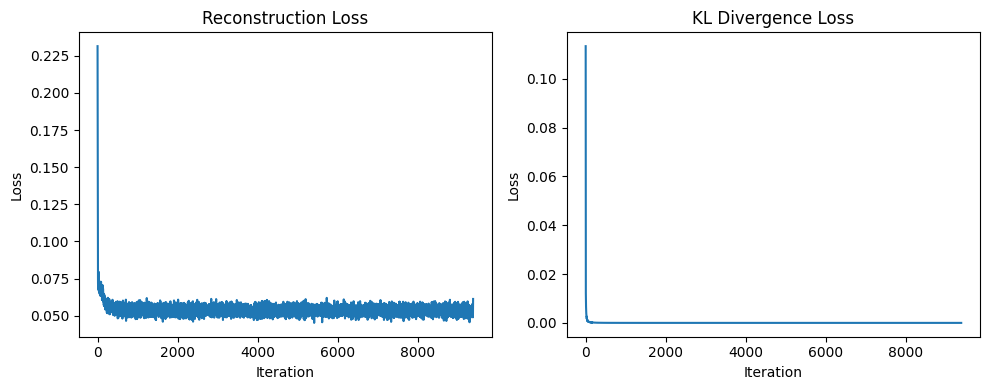

In [54]:
learning_rate = 1e-3
nz = 32
epochs = 10
beta = 0.4
conditional = True
cvae_model = CVAE(nz, beta, conditional, num_labels=10).to(device)
cvae_model = cvae_model.train()
optimizer = torch.optim.Adam(cvae_model.parameters(), lr=learning_rate)

train_it = 0
rec_loss, kl_loss = [], []
print(f"Running {epochs} epochs with {beta=}")
for ep in range(epochs):
    print(f"Run Epoch {ep}")
    for data, labels in mnist_data_loader:
        data = data.to(device)
        labels = labels.to(device)
        c = idx2onehot(labels, 10).to(device)
        optimizer.zero_grad()
        outputs = cvae_model(data, c)
        loss, losses = cvae_model.loss(data, outputs)
        loss.backward()
        optimizer.step()
        rec_loss.append(losses['rec_loss'])
        kl_loss.append(losses['kl_loss'])
        train_it += 1
        if train_it % 100 == 0:
            print(f"Iteration {train_it}, Total Loss: {loss.item():.4f}, Rec Loss: {losses['rec_loss'].item():.4f}, KL Loss: {losses['kl_loss'].item():.4f}")
print("Done!")

rec_loss_plotdata = [foo.detach().cpu() for foo in rec_loss]
kl_loss_plotdata = [foo.detach().cpu() for foo in kl_loss]

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(rec_loss_plotdata)
plt.title('Reconstruction Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.subplot(1, 2, 2)
plt.plot(kl_loss_plotdata)
plt.title('KL Divergence Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.tight_layout()
plt.show()

### Verifying conditional samples from CVAE[1 pt]
Now let us generate samples from the trained model, conditioned on all the labels.

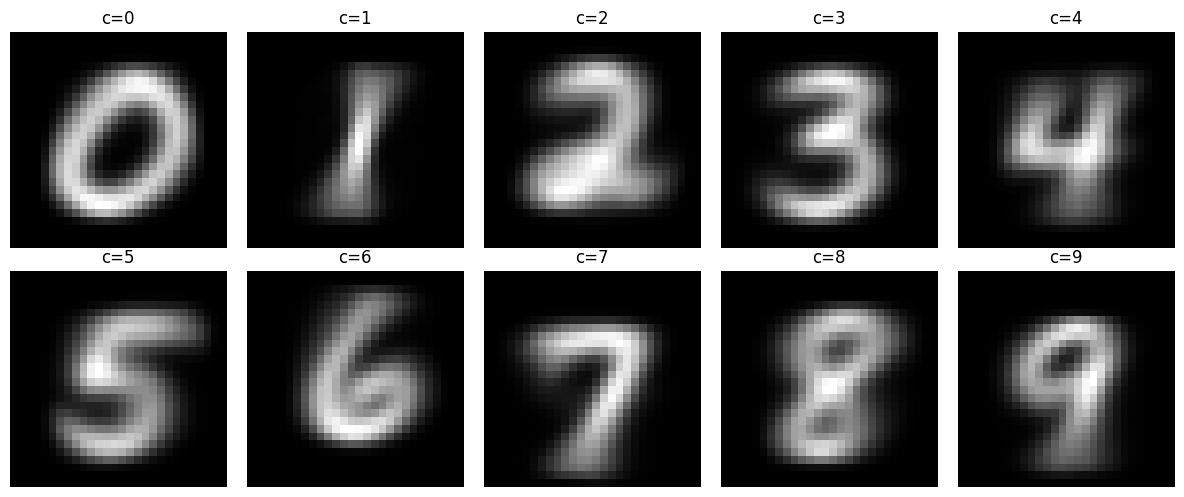

In [56]:
cvae_model.eval()

fig, axes = plt.subplots(2, 5, figsize=(12, 5))

with torch.no_grad():
    for digit in range(10):
        row = digit // 5
        col = digit % 5
        
        z_sample = torch.randn(1, nz).to(device)
        c = idx2onehot(torch.tensor([digit]), 10).to(device)
        sample = cvae_model.decoder(z_sample, c)
        
        axes[row, col].imshow(sample.squeeze().cpu(), cmap='gray')
        axes[row, col].set_title(f'c={digit}')
        axes[row, col].axis('off')

plt.tight_layout()
plt.show()

# 6. Clustering the VAE Latent Space[10 pt]

This function analyzes the structure of the **latent space** in a Variational Autoencoder (VAE) by applying **K-Means clustering** and visualizing the results.

Extract the latent space of test dataset. Use KMeans to cluster this space and plot it in 2d space.

Plot one image from each cluster to see if they really represent labels from real dataset.

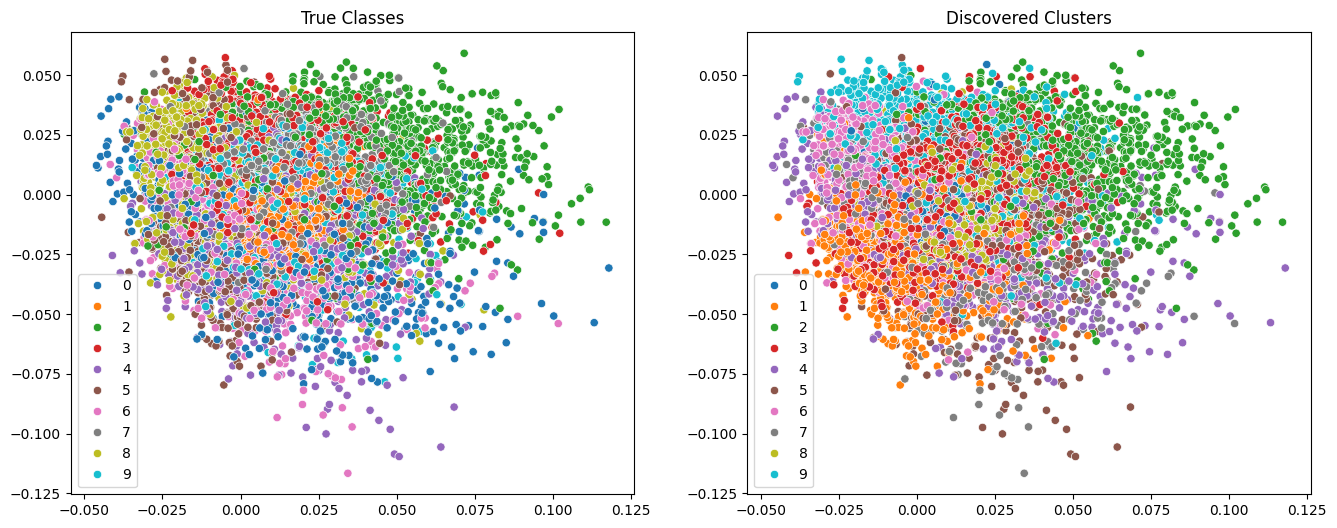

In [23]:
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


test_loader = DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.ToTensor(), download=True),
    batch_size=64, shuffle=False
)


def cluster_latent_space(vae_model, dataloader, n_clusters, device):
    vae_model.eval()
    latents = []
    labels = []

    with torch.no_grad():
        for img, label in dataloader:
            img = img.to(device)
            
            enc = vae_model.encoder(img)
            mu = enc[:, :vae_model.nz]
            latents.append(mu.cpu())
            labels.append(label)

    latents = torch.cat(latents).numpy()
    labels = torch.cat(labels).numpy()

    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(latents)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
    sns.scatterplot(x=latents[:,0], y=latents[:,1], hue=labels, palette='tab10', ax=ax1)
    ax1.set_title('True Classes')
    sns.scatterplot(x=latents[:,0], y=latents[:,1], hue=clusters, palette='tab10', ax=ax2)
    ax2.set_title('Discovered Clusters')
    plt.show()
    return kmeans

kmeans = cluster_latent_space(vae_model, test_loader, 10, device)

This code extends the **Variational Autoencoder (VAE)** by adding a **classification head**. This allows the model to **predict class labels** from the latent space.

Add a linear layer that gets encoding of image as input and outputs the image's label. Change the forward function to also returns class logits. You can also add a classify function to returns just the class logits.

In [24]:
class VAEWithClassifier(VAE):
    def __init__(self, nz, num_classes):
        super().__init__(nz)
        self.classifier = nn.Linear(nz, num_classes)

    def forward(self, x):
        enc = self.encoder(x)
        mu = enc[:, :self.nz]
        log_sigma = enc[:, self.nz:]
        epsilon = torch.randn_like(mu)
        z = mu + torch.exp(log_sigma) * epsilon
        reconstruction = self.decoder(z)
        q = {'mu': mu, 'log_sigma': log_sigma}
        
        class_logits = self.classifier(mu)
        return class_logits

Load the pretrained vae weights, then use CrossEntropyLoss to train the model for a few epochs.

In [25]:
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
test_dataset = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)
mnist_test = DataLoader(test_dataset, batch_size=64, shuffle=False)
def fine_tune_vae(pretrained_vae, train_loader, test_loader, num_classes, num_epochs=5, learning_rate=1e-3, device=device):
    model = VAEWithClassifier(nz=32, num_classes=num_classes).to(device)

    model.load_state_dict(pretrained_vae.state_dict(), strict=False)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for batch_idx, (data, labels) in enumerate(train_loader):
            data, labels = data.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(data)

            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

    return model


num_classes = 10
fine_tuned_model = fine_tune_vae(vae_model, mnist_data_loader, mnist_test, num_classes)

Epoch [1/5], Loss: 0.3316
Epoch [2/5], Loss: 0.1371
Epoch [3/5], Loss: 0.1060
Epoch [4/5], Loss: 0.0871
Epoch [5/5], Loss: 0.0745


Evaluate fine tuned model on test data.

In [26]:
fine_tuned_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data, labels in mnist_test:
        data, labels = data.to(device), labels.to(device)
        outputs = fine_tuned_model(data)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 97.03%
